In [417]:
import copy
import math
import os
import pickle
import sys

import gensim
import lucem_illud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.manifold
from ksvd import ApproximateKSVD
from tqdm import tqdm

%matplotlib inline
tqdm.pandas()

### Constants and Utility Functions

In [418]:
# Constants
MAX_CHAR_LEN = 5000000

In [419]:
# Utility Functions
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector


def dimension(model, positives, negatives):
    diff = sum([normalize(model.wv[x]) for x in positives]) - sum(
        [normalize(model.wv[y]) for y in negatives]
    )
    return diff


def coloring(series: pd.Series):
    x = series.values
    y = x - x.min()
    z = y / y.max()
    colors = list(plt.cm.rainbow(z))
    return colors


def plot_dimension(axis, df: pd.DataFrame, dim):
    axis.set_frame_on(False)
    axis.set_title(dim, fontsize=20)
    colors = coloring(df[dim])
    for idx, df_word in enumerate(df.index):
        axis.annotate(
            df_word, (0, df[dim][idx]), color=colors[idx], alpha=0.6, fontsize=12
        )
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY, MaxY)
    plt.yticks(())
    plt.xticks(())

In [420]:
# Unused utils due to sum() error
def calc_syn0norm(mdl):
    """since syn0norm is now deprecated"""
    return (mdl.wv.syn0 / np.sqrt((mdl.wv.syn0**2).sum(-1))[..., np.newaxis]).astype(
        np.float32
    )


def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words:
        common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return m1, m2

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(
        key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"),
        reverse=True,
    )

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        new_arr = [m.wv.get_vector(w, norm=True) for w in common_vocab]

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        # old_vocab = m.wv.index_to_key
        new_vocab = []
        k2i = {}
        for new_index, common_word in enumerate(common_vocab):
            new_vocab.append(common_word)
            k2i[word] = new_index
        m.wv.index_to_key = new_vocab
        m.wv.key_to_index = k2i
        m.wv.vectors = np.array(new_arr)

    return m1, m2


def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(
        base_embed, other_embed, words=words
    )

    # get the embedding matrices
    # base_vecs = calc_syn0norm(in_base_embed)
    # other_vecs = calc_syn0norm(in_other_embed)
    base_vecs = [
        in_base_embed.wv.get_vector(w, norm=True)
        for w in set(in_base_embed.wv.index_to_key)
    ]
    other_vecs = [
        in_other_embed.wv.get_vector(w, norm=True)
        for w in set(in_other_embed.wv.index_to_key)
    ]

    # just a matrix dot product with numpy
    m = np.array(other_vecs).T.dot(np.array(base_vecs))
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.vectors = (np.array(other_vecs)).dot(ortho)
    return other_embed


def raw_models(df, category, text_column_name="normalized_sentences", sort=True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        # This can take a while
        print("Embedding {}".format(cat), end="\r")
        subsetDF = df[df[category] == cat]
        # You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(
            subsetDF[text_column_name].sum()
        )
    return embeddings_raw


def compare_models(df, category, text_column_name="normalized_sentences", sort=True):
    """Prepare embeddings and align them."""
    # Generate raw embeddings
    embeddings_raw = raw_models(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))

    # Align embeddings
    embeddings_aligned = {}
    # Use the first category as the base for alignment
    base_cat = cats[0]
    for cat in cats:
        if cat == base_cat:
            embeddings_aligned[cat] = embeddings_raw[cat]
        else:
            # Align current category's embedding to the base category's embedding
            embeddings_aligned[cat] = smart_procrustes_align_gensim(
                embeddings_raw[base_cat], embeddings_raw[cat]
            )
    return embeddings_raw, embeddings_aligned


def get_divergence_df(div_word, embeddings_dict):
    """Calculate pairwise divergence for a specific word across different embeddings."""
    # Sorted categories, e.g., congress numbers
    cats = sorted(embeddings_dict.keys())
    # Initialize a square DataFrame with zeros
    df = pd.DataFrame(np.zeros((len(cats), len(cats))), index=cats, columns=cats)

    for i, cat_outer in enumerate(cats):
        for j, cat_inner in enumerate(cats):
            if i == j:
                # Divergence with itself should be 0
                df.iloc[i, j] = 0
            else:
                # Calculate cosine similarity for different congress embeddings
                vector_outer = embeddings_dict[cat_outer].wv[div_word]
                vector_inner = embeddings_dict[cat_inner].wv[div_word]
                similarity = sklearn.metrics.pairwise.cosine_similarity(
                    np.expand_dims(vector_outer, axis=0),
                    np.expand_dims(vector_inner, axis=0),
                )[0, 0]
                divergence = np.abs(1 - similarity)
                df.iloc[i, j] = divergence

    return df


def verify_embeddings(embeddings_dict, emb_word):
    """Check if any embedding vector for 'word' is invalid or significantly different."""
    for cat, model in embeddings_dict.items():
        if emb_word not in model.wv:
            print(
                f"Warning: '{emb_word}' not found in embeddings for category '{cat}'."
            )
        else:
            vector = model.wv[word]
            if np.all(vector == 0):
                print(
                    f"Warning: Embedding vector for '{word}' in category '{cat}' is all zeros."
                )


def do_aksvd(
    w2v_model,
    n_comp,
    n_non_zeros,
    save=False,
    save_location="data/content/aksvd_models/",
):
    # https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms
    # also may adjust n iter which is default at 10, and tolerance for error
    # which is default at  tol=1e-6 #n_components is number of discourse atoms,
    # since vocab size is smallish, keep this fewer. transform_n is the number
    # of atoms (components) that a word can be a linear combo of
    aksvd_t = ApproximateKSVD(
        n_components=n_comp, transform_n_nonzero_coefs=n_non_zeros
    )
    # Dictionary is the matrix of discourse atoms.
    dictionary_t = aksvd_t.fit(w2v_model.wv.vectors).components_
    # get the alphas, which are the "weights" of each word on a discourse atoms
    alpha_t = aksvd_t.transform(w2v_model.wv.vectors)

    if save:
        outfile = open(
            str(save_location)
            + "200d_"
            + str(n_comp)
            + "comp"
            + str(n_non_zeros)
            + "nonzeros_aksvd_nvdrsdf20",
            "wb",
        )
        pickle.dump(aksvd_t, outfile)
        outfile.close()

        outfile = open(
            str(save_location)
            + "200d_"
            + str(n_comp)
            + "comp"
            + str(n_non_zeros)
            + "nonzeros_dictionary_nvdrsdf20",
            "wb",
        )
        pickle.dump(dictionary_t, outfile)
        outfile.close()

        outfile = open(
            str(save_location)
            + "200d_"
            + str(n_comp)
            + "comp"
            + str(n_non_zeros)
            + "nonzeros_alpha_nvdrsdf20",
            "wb",
        )
        pickle.dump(alpha_t, outfile)
        outfile.close()
    return dictionary_t, alpha_t


def reconstruct_quality(w2v_model, dictionary_mat, alpha_mat):
    # reconstruct word vectors and add back in mean(?). but note that
    # reconstructed norm is still around 0-1, not 1, is that an issue?
    # total reconstruction error, larger means MORE error. norm as specified
    # here takes frobenius norm of error matrix.
    # e1 = norm(w2vmodel.wv.vectors - reconstructed)
    # reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat)

    # https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    # total VARIANCE in the data: sum of squares
    squares3 = w2v_model.wv.vectors - np.mean(w2v_model.wv.vectors, axis=1).reshape(
        -1, 1
    )
    # sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3 = np.sum(np.square(squares3))

    # https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    # total sum of squared ERRORS/residuals
    e3 = [
        reconstructed[idx] - w2v_model.wv.vectors[idx]
        for idx in range(0, len(w2v_model.wv.vectors))
    ]

    # sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3 = np.sum(np.square(e3))

    # https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error
    # R^2: 1- (SSE / SST )
    r2 = 1 - (sse3 / sst3)

    # compute root mean square error
    root_mean_square_error = math.sqrt(np.mean(np.square(e3)))

    return sse3, root_mean_square_error, r2


def topic_diversity(w2v_model, dictionary_mat, top_n=25):
    # list of list, each inner list includes top N words in that topic
    top_words = []

    # set to number of total topics
    for i_dict in range(0, len(dictionary_mat)):
        # set for top N words
        top_words.extend(
            [
                idx[0]
                for idx in w2v_model.wv.similar_by_vector(
                    dictionary_mat[i_dict], topn=top_n
                )
            ]
        )

    uniquewords = set(top_words)
    diversity = len(uniquewords) / len(top_words)
    return diversity

# <font color="red">*Pitch Your Project*</font>
<font color="red">In the three cells immediately following, describe **WHAT** you are 
planning to analyze for your final project (i.e., texts, contexts and the social game, 
world and actors you intend to learn about through your analysis) (<200 words), **WHY** 
you are going to do it (i.e., why would theory and/or the average person benefit from 
knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate 
it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield 
this insight) (<400 words).

## ***What? (<200 words)***
For our project, Chanteria Milner and I will analyze congressional and Supreme Court 
abortion-related legislation. Particularly for the congressional legislation, we will explore 
all legislation from 1973 until 2024. We sourced this legislation from the congress.gov 
legislation search, where we filtered for any legislation within this period that could 
have become bills and included the following keywords in the bill text or summary: 
'abortion,' 'reproduction,' or 'reproductive health care.' For the SCOTUS abortion 
legislation, we targeted SCOTUS decisions outlined on supreme.justia.com, which provides a 
list of abortion-relevant SCOTUS decisions from 1965-2022. Through this analysis, we 
plan to uncover the ways that the legislative abortion discourse has changed over time and 
the prominent congressional bills that have occurred throughout subsequent pieces of legislation. 
We will supplement this analysis with legislation in its political history by taking 
note of the political affiliations of congress members, SCOTUS justices, and the presidency.

Chanteria Milner: [Link](https://github.com/chanteriam)
Michael Plunkett: [Link](https://github.com/michplunkett)\
Congressional source: [Link](https://www.congress.gov/advanced-search/legislation?congressGroup%5B%5D=0&congresses%5B%5D=118&congresses%5B%5D=117&congresses%5B%5D=116&congresses%5B%5D=115&congresses%5B%5D=114&congresses%5B%5D=113&congresses%5B%5D=112&congresses%5B%5D=111&congresses%5B%5D=110&congresses%5B%5D=109&congresses%5B%5D=108&congresses%5B%5D=107&congresses%5B%5D=106&congresses%5B%5D=105&congresses%5B%5D=104&congresses%5B%5D=103&congresses%5B%5D=102&congresses%5B%5D=101&congresses%5B%5D=100&congresses%5B%5D=99&congresses%5B%5D=98&congresses%5B%5D=97&congresses%5B%5D=96&congresses%5B%5D=95&congresses%5B%5D=94&congresses%5B%5D=93&legislationNumbers=&restrictionType=field&restrictionFields%5B%5D=allBillTitles&restrictionFields%5B%5D=summary&summaryField=billSummary&enterTerms=%22reproductive+health+care%22%2C+%22reproduction%22%2C+%22abortion%22&legislationTypes%5B%5D=hr&legislationTypes%5B%5D=hjres&legislationTypes%5B%5D=s&legislationTypes%5B%5D=sjres&public=true&private=true&chamber=all&actionTerms=&legislativeActionWordVariants=true&dateOfActionOperator=equal&dateOfActionStartDate=&dateOfActionEndDate=&dateOfActionIsOptions=yesterday&dateOfActionToggle=multi&legislativeAction=Any&sponsorState=One&member=&sponsorTypes%5B%5D=sponsor&sponsorTypeBool=OR&dateOfSponsorshipOperator=equal&dateOfSponsorshipStartDate=&dateOfSponsorshipEndDate=&dateOfSponsorshipIsOptions=yesterday&committeeActivity%5B%5D=0&committeeActivity%5B%5D=3&committeeActivity%5B%5D=11&committeeActivity%5B%5D=12&committeeActivity%5B%5D=4&committeeActivity%5B%5D=2&committeeActivity%5B%5D=5&committeeActivity%5B%5D=9&satellite=null&search=&submitted=Submitted)
SCOTUS source: [Link](https://supreme.justia.com/cases-by-topic/abortion-reproductive-rights/)

## ***Why? (<200 words)***
This analysis, in general, will give us an understanding of how abortion discourse has
changed over time, and specifically, what arguments were used in the passing of the 
1973 Roe v. Wade decision--and with it, the assertion of the constitutional right to 
abortion and its eventual reversal in the 2022 Dobbs v. Jackson decision. 
From this, we will be able to uncover what political mechanisms were at play that 
enabled this regression in legislation, and how such significant cases went on to influence 
congressional legislation that followed. The average person will, in general, be able 
to understand how sensitive practices are discussed in the political sphere and what 
aspects in particular are targeted for protection or not. Moreover, this analysis 
will allow individuals who want to write reproductive healthcare legislation to 
understand what arguments are more likely to work over others within certain 
political contexts.

## ***How? (<400 words)***
As stated, our project aims to analyze the evolution of abortion discourse in U.S. 
legislation, particularly between the landmark Roe v. Wade (1973) and Dobbs v. Jackson 
(2022) decisions, which established and then rescinded abortion as a constitutional 
right, respectively. We have assembled a dataset of congressional legislation from 
1973 to 2024, alongside a dataset of opinions from 13 pivotal Supreme Court cases. 
The legislative measures generally either attempt to protect the right to abortion 
or seek to ban it.

Firstly, we will apply a clustering method to categorize the congressional legislation 
into three groups: pro-abortion, anti-abortion, and unrelated (noise). We will review 
and discard the unrelated legislation. Subsequently, we will employ structural topic 
modeling on the two relevant clusters to explore the evolution of arguments for and 
against abortion over time. Due to the absence of specific dates on the legislation, 
we will use the congressional session number as a temporal reference.

Furthermore, we will perform a qualitative and quantitative analysis to compare 
convergent and divergent themes between the two models. This will be followed by 
a comprehensive structural topic modeling of the clustered data.

Regarding the Supreme Court cases, we plan to use them as benchmarks to categorize 
legislative sessions. For example, if a case on abortion was adjudicated in 2010 
and another in 2015, we would assess the semantic, tonal, and lexical similarities 
among all congressional legislation enacted between those years. Our hypothesis 
posits that the substance of Supreme Court opinions significantly influences 
abortion-related legislation from the time of their issuance until a subsequent 
opinion emerges. We will also determine which opinions, aside from Roe and Dobbs, 
exert the most influence on legislative documents.

In a broader analysis, we aim to identify terms that are predominantly used in 
Supreme Court opinions and legislative texts, discounting procedural terminology 
prior to the analysis. This will highlight the distinct legal and authoritative 
contexts within which these discussions occur. Legislators typically seek to 
persuade their peers, while justices are more inclined to articulate informative 
opinions. We anticipate that these differing objectives will be reflected in the 
language used.

Overall, this analysis is expected to yield insights into the thematic development 
of abortion legislation and its interplay with Supreme Court rulings.

## <font color="red">*Pitch Your Sample*</font>
<font color="red">In the cell immediately following, describe the rationale behind 
your proposed sample design for your final project. What is the social game, social 
work, or social actors you about whom you are seeking to make inferences? What are 
its virtues with respect to your research questions? What are its limitations? What 
are alternatives? What would be a reasonable path to "scale up" your sample for 
further analysis (i.e., high-profile publication) beyond this class?.

## ***Which words? (<300 words)***
Starting in the early 1970s with the adoption of the Hyde Amendment, the amendment 
that prevented federal funding of abortions through Medicaid, anti-abortion advocates 
have attempted to reverse the Roe decision through a multitude of avenues. These efforts 
eventually culminated in the Dobbs v. Jackson decision in 2022. The elevation of the Dobbs 
v. Jackson case was not something that happened by random chance but instead was the result 
of decades of concerted efforts by anti-abortion advocates, think tanks, and political 
action committees. In our project, we intend to see how the social game of these groups 
probing for judicial vulnerabilities changed over time and the language that made up 
those attempts. The actors in this study are primarily the congressional legislators 
and supreme court justices, whom we will study via their decisions and proposed pieces 
of legislation, respectively. This analysis will give us a direct look into the 
terminology used to overturn Roe in its successful and unsuccessful cases.

Our analysis in this project will undoubtedly give us some valuable insights, but it 
will not allow us to create the entire picture. The sources we are using only capture 
the result of the efforts made by anti-abortion advocates, etc. A more complete design 
of this analysis would take documents from conservative think tanks like the Heritage 
Foundation, Family Research Council, Moral Majority, etc. Taking in documents from 
these organizations and other similarly minded ones would give us insight into the 
documents upstream from the legislative and decision documents we're currently 
assessing. To scale this project up for a high-profile journal, we could get 
documents from those organizations listed and look for similarities between them 
and the documents we're currently examining to see the complete evolution of the 
language from its initial planning to attempts at federal implementation.

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents 
related to your final project using at least two different specification of 
`word2vec` and/or `fasttext`, and visualize them each with two separate 
visualization layout specifications (e.g., TSNE, PCA). Then interrogate 
critical word vectors within your corpus in terms of the most similar words, 
analogies, and other additions and subtractions that reveal the structure of 
similarity and difference within your semantic space. What does this pattern 
reveal about the semantic organization of words in your corpora? Which 
estimation and visualization specification generate the most insight and 
appear the most robustly supported and why?

<font color="red">***Stretch***: Explore different vector calculations 
beyond addition and subtraction, such as multiplication, division or some 
other function. What does this exploration reveal about the semantic 
structure of your corpus?

In [421]:
# Load the congressional legislation
congressional_leg_df = pd.read_feather("data/tokenized_congress_legislation.feather")
congressional_leg_df.head()

,legislation number,url,congress,title,date proposed,amends amendment,latest summary,congress_num,bill_type,bill_num,api_url,text_url,raw_text,cleaned_text,cleaned_summary,kmeans_predictions,fcluster_predictions,tokenized_text,normalized_tokens,reduced_tokens
0,H.R. 2907,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,hr,2907,https://api.congress.gov/v3/bill/118/hr/2907/t...,https://www.congress.gov/118/bills/hr2907/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[time, enforcement, or, protective, considerat...","[publishing, time, enforcement, protective, co...","[enforcement, consideration, specific, affecte..."
1,S. 1297,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,s,1297,https://api.congress.gov/v3/bill/118/s/1297/te...,https://www.congress.gov/118/bills/s1297/BILLS...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[Murphy, time, Hirono, enforcement, Welch, or,...","[publishing, time, van, enforcement, mrs, prot...","[enforcement, specific, affected, defined, sin..."
2,H.R. 4901,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,hr,4901,https://api.congress.gov/v3/bill/118/hr/4901/t...,https://www.congress.gov/118/bills/hr4901/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7,2,"[experience, g, Community, throughout, partici...","[publishing, experience, g, participating, tim...","[participating, tribes, centers, consideration..."
3,S. 2544,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,s,2544,https://api.congress.gov/v3/bill/118/s/2544/te...,https://www.congress.gov/118/bills/s2544/BILLS...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7,2,"[experience, 2544, g, Community, throughout, p...","[publishing, experience, g, participating, tim...","[participating, tribes, centers, consideration..."
4,H.R. 4147,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Training Act of 2023,NaN,NaN,None,118,hr,4147,https://api.congress.gov/v3/bill/118/hr/4147/t...,https://www.congress.gov/118/bills/hr4147/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,None,0,2,"[g, identification, minority, time, centers, o...","[improve, act, public, pensions, cited, publis...","[improve, establish, number, identification, p..."


In [422]:
# Since the tokenization process takes so much computational power/time, I put it
# in a feather file to avoid the time when re-running this analysis.
legislation_feather_path = "data/fully_tokenized_congress_legislation.feather"
if os.path.isfile(legislation_feather_path):
    congressional_leg_df = pd.read_feather(legislation_feather_path)
else:
    # WARNING: This step takes about 120 minutes, so don't run it unless you need to.
    congressional_leg_df["tokenized_sentences"] = congressional_leg_df[
        "cleaned_text"
    ].progress_apply(
        lambda x: [
            lucem_illud.word_tokenize(s, MAX_LEN=MAX_CHAR_LEN)
            for s in lucem_illud.sent_tokenize(x)
        ]
    )
    congressional_leg_df["normalized_sentences"] = congressional_leg_df[
        "tokenized_sentences"
    ].apply(
        lambda x: [
            lucem_illud.normalizeTokens(s, lemma=False, MAX_LEN=MAX_CHAR_LEN) for s in x
        ]
    )
    congressional_leg_df.to_feather(legislation_feather_path)

In [423]:
# Load saved Word2Vec if it exists
word2vec_file_path = "data/congressional_leg_w2v"
if os.path.isfile(word2vec_file_path):
    congressional_leg_w2v = gensim.models.word2vec.Word2Vec.load(word2vec_file_path)
else:
    congressional_leg_w2v = gensim.models.word2vec.Word2Vec(
        congressional_leg_df["normalized_sentences"].sum(), sg=0
    )
    congressional_leg_w2v.save(word2vec_file_path)

In [424]:
# Going to look at words commonly associated with abortion
congressional_leg_w2v.wv.most_similar(["abortion"])

[('abortions', 0.7506675720214844),
 ('induced', 0.5621079802513123),
 ('sterilization', 0.5290029048919678),
 ('counsels', 0.4976457953453064),
 ('unemancipated', 0.4902770221233368),
 ('obstetric', 0.48109883069992065),
 ('audible', 0.4639524221420288),
 ('heartbeat', 0.4593304991722107),
 ('mifepristone', 0.4592679738998413),
 ('mother', 0.4591161906719208)]

A common assertion in anti-abortion circles is that if you go through an abortion
you are potentially sterilizing yourself or dropping the likelihood of your ability
to conceive in the future, which makes the 'sterilization' similarity notable. The
other most interesting similarity is 'unemancipated', which references an individual
who is still under parental control. A large amount of abortion-related legislation
focused on whether it was required for the parent to be informed if their child
sought an abortion, so this contextually tracks well.

In [425]:
# Selecting the top 50 words from the congressional_leg_w2v dataset
# and getting their respective vectors for further analysis.
num_words = 50
target_words = congressional_leg_w2v.wv.index_to_key[:num_words]
words_sub_matrix = []
for word in target_words:
    words_sub_matrix.append(congressional_leg_w2v.wv[word])
words_sub_matrix = np.array(words_sub_matrix)
words_sub_matrix[:5]

array([[ 7.01243401e-01, -1.98045814e+00,  1.69280827e+00,
         8.64630699e-01,  1.28717864e+00, -5.05317926e-01,
         1.13872695e+00, -2.17121810e-01, -1.38199258e+00,
         1.16776371e+00,  2.82135320e+00,  4.74404097e-01,
        -3.11058462e-01, -1.73494726e-01,  1.05794823e+00,
         1.39646626e+00,  1.01622498e+00, -1.30117428e+00,
        -2.61231840e-01,  9.96614575e-01, -6.59144282e-01,
        -4.11819428e-01,  7.32142508e-01, -1.99674547e-01,
         3.31748748e+00, -2.29842734e+00, -4.37350893e+00,
        -1.30481589e+00, -2.22346663e+00, -1.30300462e+00,
         6.20443821e-01,  1.42162040e-01,  1.34954011e+00,
         2.79951620e+00,  3.97904456e-01,  1.75277984e+00,
         1.36425173e+00, -1.13644588e+00, -8.94096136e-01,
         6.47117555e-01, -1.69223821e+00,  6.92348063e-01,
        -1.36289850e-01,  2.51146340e+00, -6.26908243e-01,
        -1.36617064e+00, -1.78015813e-01,  4.45258665e+00,
        -8.76562536e-01,  1.37046635e+00, -9.68483627e-0

In [426]:
def plot_words(word_decompositions, t_words: [str] = target_words) -> None:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(
        word_decompositions[:, 0], word_decompositions[:, 1], alpha=0
    )  # Making the points invisible
    for i, t_word in enumerate(t_words):
        ax.annotate(
            t_word,
            (word_decompositions[:, 0][i], word_decompositions[:, 1][i]),
            size=20 * (num_words - i) / num_words,
        )
    plt.xticks(())
    plt.yticks(())
    plt.show()


# Do word analysis using reduced-PCA and T-SNE
pca_words = sklearn.decomposition.PCA(n_components=num_words).fit(words_sub_matrix)
reduced_pca_words = pca_words.transform(words_sub_matrix)
# T-SNE is theoretically better, but you should experiment
tsne_words = sklearn.manifold.TSNE(n_components=2).fit_transform(reduced_pca_words)

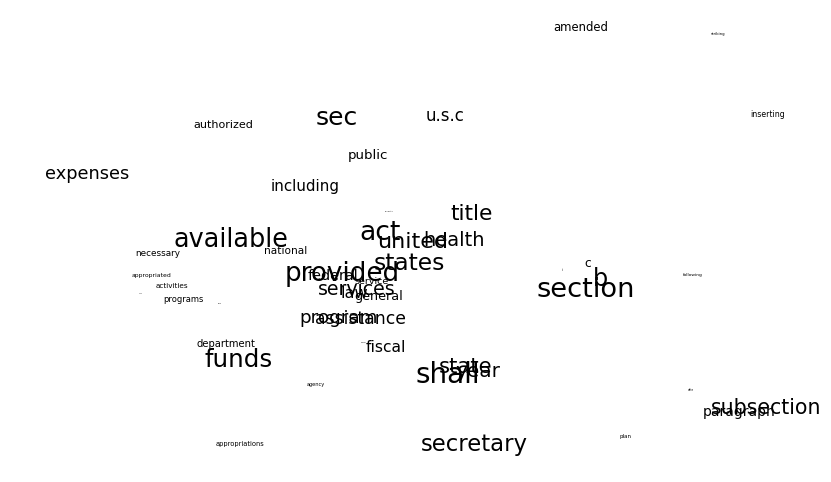

In [427]:
# Create a word cloud of the reduced PCA analysis
plot_words(reduced_pca_words)

The biggest words in the PCA analysis appear to be provided states, available, 
section (c is also there, so I assume it should be c-section), funds, states 
(could be centered around states rights or United States), services, etc. 
This tracks with the assumption that legislation would focus on the availability 
of services, fiscal policy, and states' rights. 

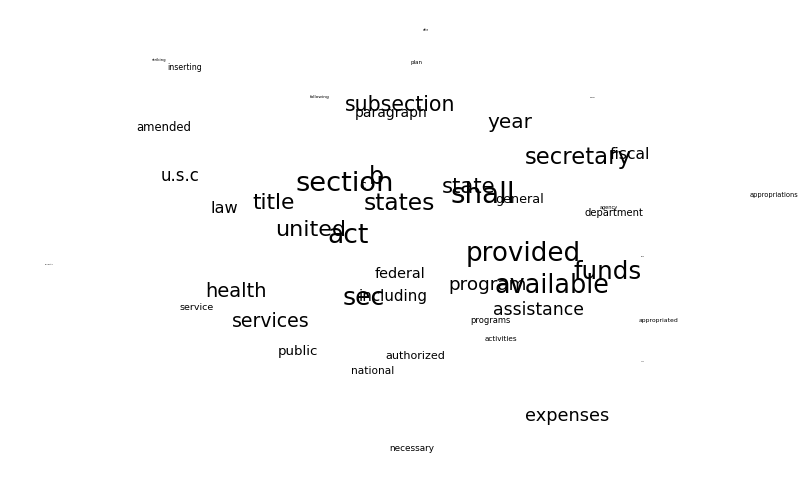

In [428]:
# Create a word cloud of the T-SNE analysis
plot_words(tsne_words)

Similar to the reduced PCA analysis, the T-SNE analysis notes the focus on section (presumably 
'c-section'), funds, states (presumably states rights), funds, expenses, etc. Aside from health
related terms like health, c-section, service, etc. the legislation is more focused on fiscal
policy than anything else. This tracks with our presumption that instead of going for the moving on
the medical aspects of the procedure, anti-abortion legislators would focus on the monetary aspects
of the procedure.

Between the PCA and T-SNE analysis, I found them to be equally useful. Perhaps it is the size
of our corpora, the general redundancy of the legislation, or something I am unaware of, but
they both appear to give very similar descriptions of the data. Going forward, and presuming
that running both of them does not take a prohibitively long amount of time, I think it'd
be worth to include both of them in our analysis. Since T-SNE is more well regarded, it
appears that we could just use that analysis without missing any particular insights.

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed 
documents related to your final project using `doc2vec`, and explore 
the relationship between different documents and the word vectors you 
analyzed in the last exercise. Consider the most similar words to 
critical documents, analogies (doc _x_ + word _y_), and other additions 
and subtractions that reveal the structure of similarity and difference 
within your semantic space. What does this pattern reveal about the 
documentary organization of your semantic space?

In [429]:
keywords = [
    "abortion",
    "states",
    "rights",
    "available",
    "health",
    "services",
    "funds",
    "abortions",
    "unemancipated",
]
tagged_docs = []
for index, row in congressional_leg_df.iterrows():
    # Simple keyword assignment
    doc_keywords = [s for s in keywords if s in row["normalized_tokens"]]
    doc_keywords.append(row["congress_num"])
    # This lets us extract individual documents since legislation numbers are unique
    doc_keywords.append(row["legislation number"])
    tagged_docs.append(
        gensim.models.doc2vec.TaggedDocument(
            words=row["normalized_tokens"], tags=doc_keywords
        )
    )
congressional_leg_df["tagged_text"] = tagged_docs

In [430]:
congressional_leg_d2v = gensim.models.doc2vec.Doc2Vec(
    congressional_leg_df["tagged_text"], vector_size=100
)

In [431]:
# Show vector of particular congressional number
congressional_leg_d2v.docvecs[118]

array([ 3.8035204 ,  1.798801  ,  0.5938901 ,  1.1992674 ,  2.1899126 ,
        1.2242241 ,  0.41832054, -0.6206017 , -0.04931653,  2.9012845 ,
        2.428162  ,  0.4884067 ,  1.2693411 ,  1.8710747 ,  2.8367045 ,
        0.9456748 ,  0.34631777, -0.27230585,  0.8643912 ,  3.4587424 ,
       -1.946804  , -1.6050951 ,  0.34673777, -2.8877866 ,  1.0889708 ,
       -0.12566625,  1.0799179 ,  1.6936126 ,  2.9930975 ,  0.42270213,
       -0.6233158 , -0.83509296, -2.3233218 ,  0.18997683,  2.6911457 ,
       -0.32451376,  1.0558798 ,  0.60784376, -0.5422182 ,  0.4086508 ,
        2.448126  ,  2.1828783 , -1.362301  , -0.41087884, -2.7459636 ,
       -0.24385305,  1.1353424 ,  1.1206331 ,  1.7887852 , -0.15713677,
        1.38945   , -0.15960798, -2.6946118 ,  0.14853789,  1.8522507 ,
       -0.16124634,  0.6576111 , -2.7506175 ,  1.7044603 ,  1.6995926 ,
       -1.0834713 ,  1.1129047 , -2.1245074 , -1.6613463 ,  2.2927063 ,
       -0.91203415, -0.01290411, -1.952815  ,  0.4297548 , -0.31

In [432]:
# Show vectors for the word abortion in various documents.
congressional_leg_d2v["abortion"]

array([ 0.56629395, -0.50753266,  2.6096582 ,  3.5237365 , -1.6494772 ,
       -1.6605734 , -2.9046698 ,  4.632927  ,  1.5485672 ,  4.981438  ,
        0.58295983, -0.9105121 , -1.0891644 ,  4.77286   ,  0.30873257,
       -4.206518  ,  2.7128277 ,  1.1127871 , -0.3719555 , -2.1032238 ,
       -1.0272118 , -3.5594385 , -1.572179  ,  2.1099777 , -0.7341789 ,
        3.4886878 , -0.28933686,  4.2833714 , -4.05157   ,  1.131035  ,
        5.61723   , -1.3121995 ,  0.8994754 , -2.4615579 , -1.0511504 ,
       -0.58010125,  0.3702789 , -1.9098    , -4.076133  ,  4.270097  ,
       -1.8080677 ,  0.33583924, -0.276958  , -0.70315456, -5.488995  ,
       -4.6060405 , -1.9904951 ,  0.69916844,  0.18104069,  2.379133  ,
       -2.8362088 , -0.1055399 ,  4.634508  ,  3.388186  ,  3.989286  ,
        2.0673807 ,  0.2694623 , -1.5400636 ,  2.9919708 ,  1.8771794 ,
        0.8189491 , -2.7890234 , -2.2006168 , -1.119348  ,  3.9493198 ,
        8.307829  , -0.04673207,  3.4779863 , -1.1677883 , -2.44

In [433]:
abortion_similar = congressional_leg_d2v.docvecs.most_similar(
    [congressional_leg_d2v["abortion"]], topn=sys.maxsize
)
list(abortion_similar[:10])

[('H.R. 563', 0.712124764919281),
 ('H.R. 8190', 0.6874495148658752),
 ('S. 204', 0.6806740760803223),
 ('H.R. 4391', 0.6800211071968079),
 ('H.R. 1833', 0.6642701029777527),
 ('S. 167', 0.6623290777206421),
 ('H.R. 2277', 0.6608039140701294),
 ('H.R. 3197', 0.6604380011558533),
 ('H.R. 5637', 0.6451203227043152),
 ('S. 565', 0.6437715888023376)]

The most similar function tells us the documents most closely related
to the word abortion, based on our vectors. I could use the output of
the above function call to look at legislation documents that most directly
address abortion.

In [434]:
list(abortion_similar[-10:])

[('H.R. 2541', -0.6339306235313416),
 ('H.R. 2712', -0.6412248611450195),
 ('S. 1877', -0.6415760517120361),
 ('S. 83', -0.642593502998352),
 ('H.R. 1304', -0.6455617547035217),
 ('H.R. 4409', -0.6494405269622803),
 ('H.R. 4147', -0.6504755020141602),
 ('H.R. 8034', -0.6703633069992065),
 ('H.R. 1430', -0.6763629913330078),
 ('S. 3649', -0.702163577079773)]

This reversed list of that same query gives us a look into documents
that could match one of two criteria: they indirectly legislate abortion,
or they incorrectly came up via the legislative search. Presuming it is
the former, the documents are worth investigating on the basis that
we have a corpus that tells us how you can legislate abortion without
directly mentioning it.

In [435]:
abortions_similar = congressional_leg_d2v.docvecs.most_similar(
    [congressional_leg_d2v["abortions"]], topn=sys.maxsize
)
unemancipated_similar = congressional_leg_d2v.docvecs.most_similar(
    [congressional_leg_d2v["unemancipated"]], topn=sys.maxsize
)

In [436]:
# Show the set of documents that were in the top 20 MOST similar for each compiled list.
print(
    set([a[0] for a in abortion_similar[:20]]).intersection(
        set([a[0] for a in abortions_similar[:20]]),
        set([u[0] for u in unemancipated_similar[:20]]),
    )
)
# Show the set of documents that were in the top 20 LEAST similar for each compiled list.
print(
    set([a[0] for a in abortion_similar[-20:]]).intersection(
        set([a[0] for a in abortions_similar[-20:]]),
        set([u[0] for u in unemancipated_similar[-20:]]),
    )
)

{'H.R. 563', 'S. 204'}
{'H.R. 8916', 'H.J.Res. 133', 'H.R. 1430'}


Taking three of the most similar words to 'abortion' from question 1,
I looked to see which documents were in the top 20 of the most similar
and dissimilar lists for abortion, abortions, and unemancipated. I think
these sets present us with documents that notably converge and diverge
on some of the most relevant terms in our dataset, marking them as documents
worth diving further into.

In [437]:
# Piggybacking off of the work in the homework, I'll take a look at our
# previously keyword list and the first 10 pieces of legislation in our
# dataframe.
heatmap_matrix = []
target_docs = congressional_leg_df["legislation number"][:10]

for tag_outer in target_docs:
    column = []
    tag_vec = congressional_leg_d2v.docvecs[tag_outer].reshape(1, -1)
    for tag_inner in keywords:
        column.append(
            sklearn.metrics.pairwise.cosine_similarity(
                tag_vec, congressional_leg_d2v.docvecs[tag_inner].reshape(1, -1)
            )[0][0]
        )
    heatmap_matrix.append(column)
heatmap_matrix = np.array(heatmap_matrix)

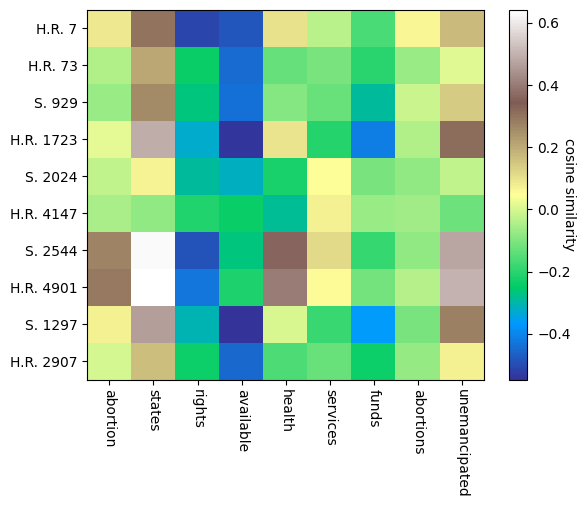

In [438]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmap_matrix, cmap="terrain")
cbar = plt.colorbar(hmap)

cbar.set_label("cosine similarity", rotation=270)
_ = ax.set_xticks(np.arange(heatmap_matrix.shape[1]) + 0.5, minor=False)
_ = ax.set_yticks(np.arange(heatmap_matrix.shape[0]) + 0.5, minor=False)

_ = ax.set_xticklabels(keywords, minor=False, rotation=270)
_ = ax.set_yticklabels(target_docs, minor=False)

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed 
documents related to your final project, then generate meaningful 
semantic dimensions based on your theoretical understanding of the 
semantic space (i.e., by subtracting semantically opposite word vectors) 
and project another set of word vectors onto those dimensions. Interpret 
the meaning of these projections for your analysis. Which of the dimensions 
you analyze explain the most variation in the projection of your words and why?

<font color="red">***Stretch***: Average together multiple antonym pairs to 
create robust semantic dimensions. How do word projections on these robust 
dimensions differ from single-pair dimensions?

In [439]:
congressional_leg_df.head()

,legislation number,url,congress,title,date proposed,amends amendment,latest summary,congress_num,bill_type,bill_num,...,cleaned_text,cleaned_summary,kmeans_predictions,fcluster_predictions,tokenized_text,normalized_tokens,reduced_tokens,tokenized_sentences,normalized_sentences,tagged_text
0,H.R. 2907,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,hr,2907,...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[time, enforcement, or, protective, considerat...","[publishing, time, enforcement, protective, co...","[enforcement, consideration, specific, affecte...","[[Congressional, Bills, 118th, Congress, From,...","[[congressional, bills, congress, u.s, governm...","([publishing, time, enforcement, protective, c..."
1,S. 1297,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,s,1297,...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[Murphy, time, Hirono, enforcement, Welch, or,...","[publishing, time, van, enforcement, mrs, prot...","[enforcement, specific, affected, defined, sin...","[[Congressional, Bills, 118th, Congress, From,...","[[congressional, bills, congress, u.s, governm...","([publishing, time, van, enforcement, mrs, pro..."
2,H.R. 4901,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,hr,4901,...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7,2,"[experience, g, Community, throughout, partici...","[publishing, experience, g, participating, tim...","[participating, tribes, centers, consideration...","[[Congressional, Bills, 118th, Congress, From,...","[[congressional, bills, congress, u.s, governm...","([publishing, experience, g, participating, ti..."
3,S. 2544,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,s,2544,...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7,2,"[experience, 2544, g, Community, throughout, p...","[publishing, experience, g, participating, tim...","[participating, tribes, centers, consideration...","[[Congressional, Bills, 118th, Congress, From,...","[[congressional, bills, congress, u.s, governm...","([publishing, experience, g, participating, ti..."
4,H.R. 4147,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Training Act of 2023,NaN,NaN,None,118,hr,4147,...,Congressional Bills 118th Congress From the U....,None,0,2,"[g, identification, minority, time, centers, o...","[improve, act, public, pensions, cited, publis...","[improve, establish, number, identification, p...","[[Congressional, Bills, 118th, Congress, From,...","[[congressional, bills, congress, u.s, governm...","([improve, act, public, pensions, cited, publi..."


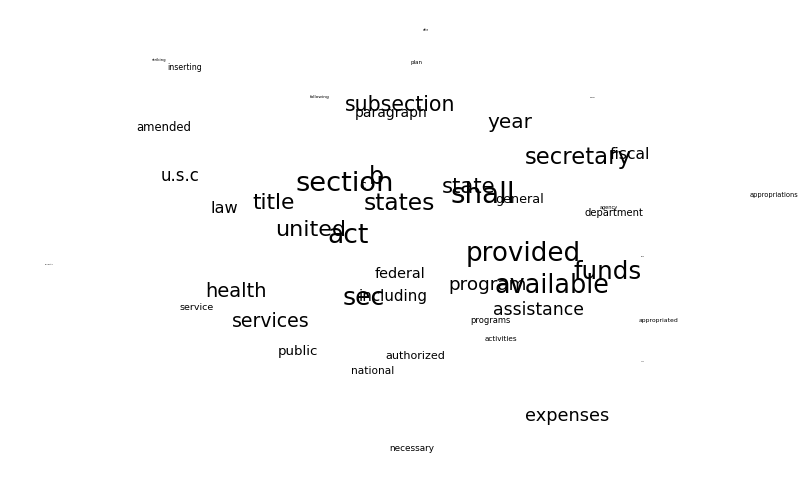

In [440]:
# Create a word cloud of the T-SNE analysis, so we can grab some dimensions.
plot_words(tsne_words)

In [441]:
financial = dimension(
    congressional_leg_w2v,
    ["appropriations", "appropriated", "provided"],
    ["funds", "fiscal", "expenses"],
)
government = dimension(
    congressional_leg_w2v, ["federal", "national"], ["state", "states"]
)

In [442]:
# Adding the DF making function for further work.
def make_df(df_model, word_list):
    f = []
    g = []
    for w in word_list:
        f.append(
            sklearn.metrics.pairwise.cosine_similarity(
                df_model.wv[w].reshape(1, -1), financial.reshape(1, -1)
            )[0][0]
        )
        g.append(
            sklearn.metrics.pairwise.cosine_similarity(
                df_model.wv[w].reshape(1, -1), government.reshape(1, -1)
            )[0][0]
        )
    df = pd.DataFrame({"financial": f, "government": g}, index=word_list)
    return df

In [443]:
# Using the top 10 most similar words to abortion and the word abortion.
keywords = [
    "abortion",
    "abortions",
    "induced",
    "sterilization",
    "counsels",
    "unemancipated",
    "obstetric",
    "audible",
    "heartbeat",
    "mifepristone",
    "mother",
]
financial_df = make_df(congressional_leg_w2v, keywords)
government_df = make_df(congressional_leg_w2v, keywords)

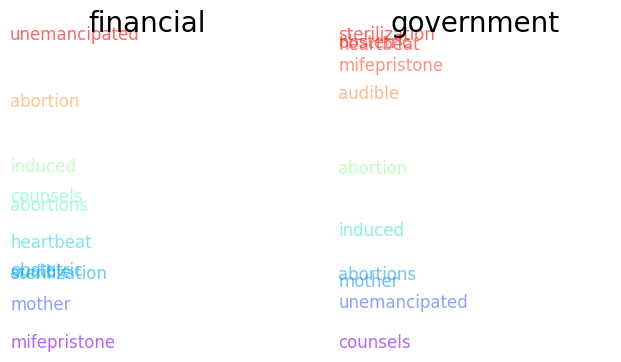

In [444]:
# Visualize keywords
ex3_fig = plt.figure(figsize=(12, 4))
ax1 = ex3_fig.add_subplot(131)
plot_dimension(ax1, financial_df, "financial")
ax2 = ex3_fig.add_subplot(132)
plot_dimension(ax2, government_df, "government")
plt.show()

The categories I chose to use for my semantic dimensions were a little loose,
as the T-SNE cloud did not give me as much to work with as I had hoped. I do
think that it's notable those that financial related words most positively associated
with unemancipated showing a correlation between financial concerns and
the family unit. I also think it's interesting that the government labels,
most positively associated not with abortion directly, but with words that
are adjacently associated with it like the sterilization, heartbeat, audible,
etc.

## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that align 
word embeddings over time or across domains/corpora. Interrogate the 
spaces that result and ask which words changed most and least over the 
entire period or between contexts/corpora. What does this reveal about 
the social game underlying your space?

In [445]:
# Using the code from last week's work to break down the bills into
# counts grouped by congressional sessions.
congress_leg_count_df = (
    congressional_leg_df.groupby("congress_num", as_index=False)
    .agg({"legislation number": "count"})
    .sort_values(by=["congress_num"])
    .rename(columns={"legislation number": "num_bills"})
)
congress_leg_count_df[:5]

,congress_num,num_bills
0,101,49
1,102,60
2,103,38
3,104,72
4,105,53


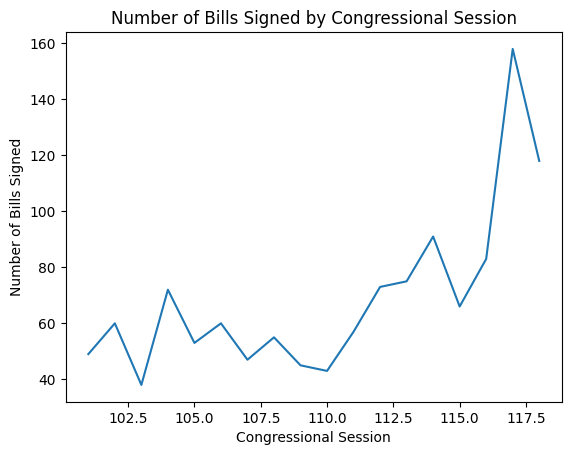

In [446]:
plt.plot(congress_leg_count_df["congress_num"], congress_leg_count_df["num_bills"])
plt.title("Number of Bills Signed by Congressional Session")
plt.xlabel("Congressional Session")
plt.ylabel("Number of Bills Signed")
plt.show()

In [447]:
congressional_leg_df["normalized_sentences"].sum()

TypeError: operands could not be broadcast together with shapes (82,) (84,) 

In [ ]:
raw_embeddings, compared_embeddings = compare_models(
    congressional_leg_df, "congress_num"
)

I had to stop here, as I could not figure out a way to get .sum() to work.
I had got it work in the creation of the initial `congressional_leg_df`
dataframe, but have been unable to do so after it's been done once. To
see if I could get a `sum()` to work more than once, I executed the 
`congressional_leg_df["normalized_sentences"].sum()` command underneath
the first time it was done for Exercise 1, and it gave me the same error
I am seeing above. This error prevented me from moving forward.